## CRISP-DM Phase 3. Data Preparation

The data preparation phase covers all activities needed to construct the final dataset [data that will be fed into the modeling tool(s)] from the initial raw data. Tasks include table, record, and attribute selection, as well as transformation and cleaning of data for modeling tools

In [1]:
import sys
sys.path.append('../src')
import utils
import data_processor
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import warnings 
warnings.filterwarnings('ignore')

# Load data
df: pd.DataFrame = utils.load_original_data()

# Data preprocessing object
processor = data_processor.DataProcessor(df)

### Converting Target Variable into binary values in conformance with a classification problem

In [2]:
# Convert Financial Distress column into 0 or 1
df['Financial Distress'] = [0 if x > -0.50 else 1 for x in df['Financial Distress']]

df.head()

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,0,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,0,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,1,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,0,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


In [3]:
# Create feature matrix and target vector 
X, y = processor.create_feature_matrix_and_target_vector("Financial Distress")

### Balancing Data

Two different techniques were combined to address class imbalance:
- SMOTE: Oversample the minority class  
- Random Undersampling: Undersample the majority class 

Counter({0: 3536, 1: 136})


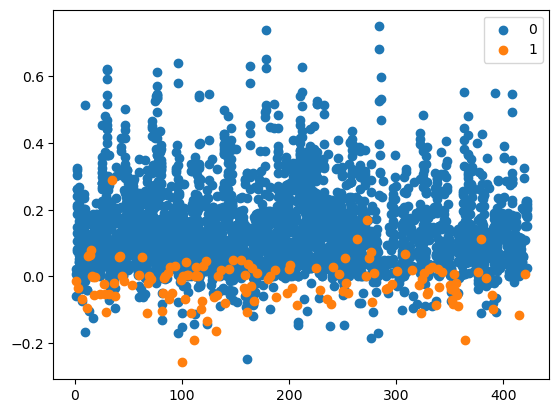

In [68]:
# Check class distribution
processor.class_distribution(X,y)

Counter({0: 2120, 1: 1060})


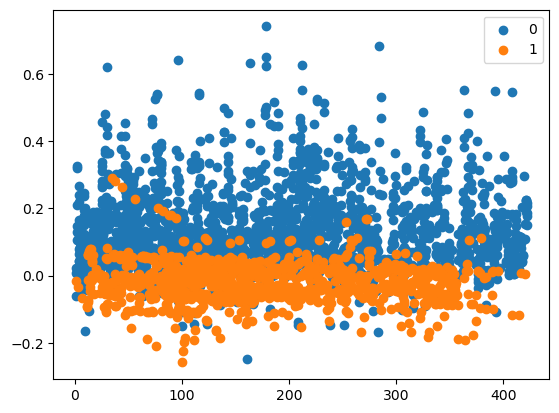

In [4]:
# Transform data with SMOTE for minority class and RandomUnderSampler for majority class to tackle class imbalance
X_sampled, y_sampled = processor.transform(X, y,0.3,0.5)

 The final class distribution after this sequence of transforms matches expectations with a 1:2 ratio or about 2,000 examples in the majority class and about 1,000 examples in the minority class.

In [9]:
sampled_sorted = X_sampled.sort_values(by=['Company'])
sampled_sorted

,Company,Time,x1,x2,x3,x4,x5,x6,x7,x8,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
1,1,2,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,0.006423,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
3,1,4,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,-0.018807,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
2,1,3,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,-0.081423,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
0,1,1,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,0.018854,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
17,2,14,2.2263,0.325880,0.40651,0.90804,0.455340,0.493550,1.65280,0.358880,...,91.700,227.50,214.500,21.000,20.5,8.6,29,2.659800,20,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671,422,14,1.6148,0.176760,0.36369,0.18442,0.169550,0.197860,1.58420,0.958450,...,91.700,227.50,214.500,21.000,20.5,8.6,37,0.611030,8,45
3665,422,8,2.0609,0.149950,0.18973,0.14381,0.132120,0.199190,1.98920,1.042700,...,84.660,73.20,63.880,16.000,12.0,1.2,37,0.351440,2,39
3670,422,13,1.5590,0.185450,0.30728,0.19307,0.172140,0.170680,1.53890,0.960570,...,92.900,203.20,204.500,22.000,22.0,6.4,37,0.500770,7,44
3669,422,12,1.7099,0.207970,0.26136,0.21399,0.193670,0.183890,1.68980,0.971860,...,87.100,175.90,178.100,20.000,14.5,-20.2,37,0.482410,6,43


In [20]:
# check if Time is monotonic and increasing for each group/company 
print("Time monotonic and increasing for each group/company in original data: {}".format(processor.check_time_monotonicity(X, "Time")))
print("Time monotonic and increasing for each group/company in sampled data: {}".format(processor.check_time_monotonicity(X_sampled, "Time")))

Time monotonic and increasing for each group/company in original data: True
Time monotonic and increasing for each group/company in sampled data: False


- It seems that the temporal order of the 'Time' column is not being preserved within each group (company) in the sampled data.

In [18]:
# Preserve temporal order of data for each group/company
X_sampled_sorted = X_sampled.sort_values(by=['Company', 'Time'])
print(X_sampled_sorted.head())

# sort y_sampled according to X_sampled_sorted 
y_sampled_sorted = y_sampled[X_sampled_sorted.index]
# reset index
y_sampled_sorted = y_sampled_sorted.reset_index(drop=True)
print(y_sampled_sorted.head())

   Company  Time      x1        x2       x3       x4        x5        x6  \
0        1     1  1.2810  0.022934  0.87454  1.21640  0.060940  0.188270   
1        1     2  1.2700  0.006454  0.82067  1.00490 -0.014080  0.181040   
2        1     3  1.0529 -0.059379  0.92242  0.72926  0.020476  0.044865   
3        1     4  1.1131 -0.015229  0.85888  0.80974  0.076037  0.091033   
4        2     1  1.0623  0.107020  0.81460  0.83593  0.199960  0.047800   

        x7        x8  ...      x74    x75     x76     x77   x78  x79  x80  \
0  0.52510  0.018854  ...   85.437  27.07  26.102  16.000  16.0  0.2   22   
1  0.62288  0.006423  ...  107.090  31.31  30.194  17.000  16.0  0.4   22   
2  0.43292 -0.081423  ...  120.870  36.07  35.273  17.000  15.0 -0.2   22   
3  0.67546 -0.018807  ...   54.806  39.80  38.377  17.167  16.0  5.6   22   
4  0.74200  0.128030  ...   85.437  27.07  26.102  16.000  16.0  0.2   29   

        x81  x82  x83  
0  0.060390   30   49  
1  0.010636   31   50  
2 -0.455

In [29]:
# sum of null values in X_sampled and y_sampled
print("Number of NaN values in X_sampled: {}".format(X_sampled_sorted.isnull().sum().sum()))
print("Number of NaN values in y_sampled: {}".format(y_sampled_sorted.isnull().sum().sum()))

Number of NaN values in X_sampled: 0
Number of NaN values in y_sampled: 0


### Scaling

In [21]:
X_scaled : pd.DataFrame = processor.scale(X_sampled_sorted)
X_scaled

,Company,Time,x1,x2,x3,x4,x5,x6,x7,x8,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,-1.600473,-1.521098,-0.010762,-0.487455,1.124555,0.710456,-0.372371,0.552442,-0.188365,-0.043127,...,-0.128096,-0.961317,-0.935924,-0.864933,0.306924,0.348554,0.390266,-0.260682,1.870355,1.235372
1,-1.600473,-1.275373,-0.018205,-0.619573,0.826754,0.327813,-0.955804,0.517264,-0.094752,-0.043129,...,1.210487,-0.894589,-0.871156,-0.358128,0.306924,0.374276,0.390266,-0.279549,1.981894,1.313957
2,-1.600473,-1.029648,-0.165094,-1.147354,1.389243,-0.170870,-0.687061,-0.145291,-0.276617,-0.043143,...,2.062364,-0.819677,-0.790767,-0.358128,-0.053897,0.297110,0.390266,-0.456495,2.093433,1.392542
3,-1.600473,-0.783924,-0.124363,-0.793406,1.037985,-0.025267,-0.254961,0.079338,-0.044413,-0.043133,...,-2.021698,-0.760976,-0.741638,-0.273492,0.306924,1.043057,0.390266,-0.406976,2.204973,1.471128
4,-1.591674,-1.521098,-0.158734,0.186659,0.793198,0.022116,0.708792,-0.131011,0.019292,-0.043109,...,-0.128096,-0.961317,-0.935924,-0.864933,0.306924,0.348554,1.392032,0.190818,-0.695052,-0.493506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,2.104038,0.198975,0.516916,0.530826,-2.661179,-1.230057,0.181198,0.605573,1.213342,-0.042962,...,-0.176130,-0.235335,-0.337982,-0.864933,-1.136360,0.477166,2.536907,-0.150311,-1.252749,0.449518
3176,2.104038,0.936149,0.449663,1.063873,-2.599153,-1.098692,0.737022,0.560226,1.164515,-0.042969,...,0.246717,0.666438,0.746537,1.162287,-0.234308,-1.734954,2.536907,-0.117478,-0.918131,0.685274
3177,2.104038,1.181874,0.279431,0.995970,-2.265198,-1.103088,0.659874,0.531131,0.926701,-0.042974,...,-0.025290,1.380931,1.469866,1.162287,-0.234308,-2.275123,2.536907,-0.100645,-0.806591,0.763860
3178,2.104038,1.427599,0.177332,0.815428,-2.011345,-1.140936,0.492435,0.466858,0.782231,-0.042976,...,0.333264,1.810572,1.887720,2.175897,2.471849,1.145946,2.536907,-0.093682,-0.695052,0.842445


### Feature Extraction and Selection

RFE (To Do)

### Save Data

In [26]:
# Append X and Y to create a single data frame
df_model = pd.DataFrame(X_scaled)
df_model['Financial Distress'] = y_sampled_sorted

# save data
with open('../data/processed/financial_data_processed.pkl', 'wb') as f:
    pkl.dump(df_model, f)